In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')

In [2]:
df = pd.read_csv('strava_data.csv',
                parse_dates=['date'],
                dtype={'time_bins':'category'})

df['time_bins'] = df['time_bins'].cat.set_categories(['4am-8am', '8am-12pm', '12pm-4pm', '4pm-8pm'], ordered=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    1969 non-null   object        
 1   distance                1969 non-null   float64       
 2   moving_time             1969 non-null   float64       
 3   elapsed_time            1969 non-null   float64       
 4   total_elevation_gain    1969 non-null   float64       
 5   sport_type              1969 non-null   object        
 6   id                      1969 non-null   int64         
 7   achievement_count       1969 non-null   int64         
 8   kudos_count             1969 non-null   int64         
 9   comment_count           1969 non-null   int64         
 10  athlete_count           1969 non-null   int64         
 11  private                 1969 non-null   bool          
 12  visibility              1969 non-null   object  

In [3]:
df = df.loc[df['date'].dt.year == 2022]

# 2022 Totals

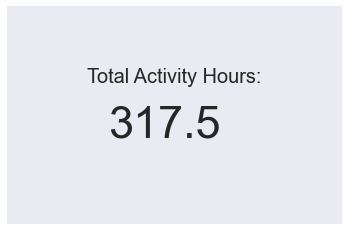

In [4]:
fig, ax = plt.subplots()

plt.text(
    x=.50, 
    y=.65, 
    s='Total Activity Hours:',
    horizontalalignment='center',
    fontsize=20
)

plt.text(
    x=.30, 
    y=.40, 
    s=str(round(df.loc[:,'moving_time'].sum() / 60, 1)),
    fontsize=45
)

for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)
    
plt.xticks([])
plt.yticks([])

plt.show()

In [14]:
total_volume = df.set_index('date').loc[:,['moving_time', 'distance']].resample('M').sum()

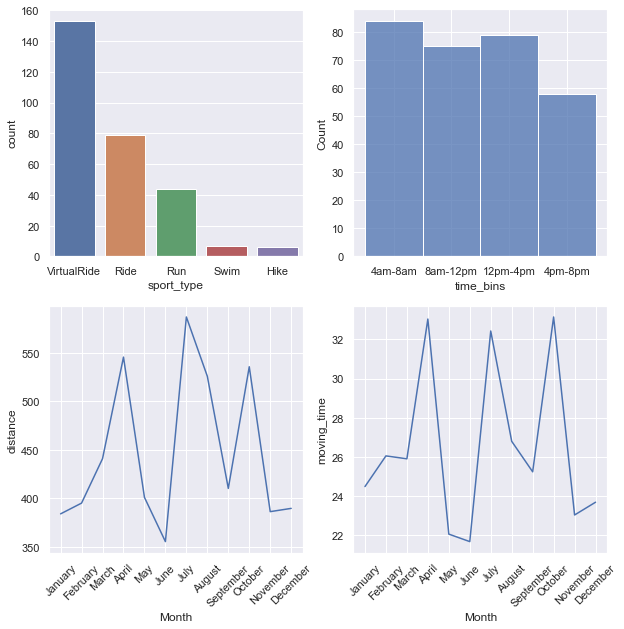

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

sns.countplot(
    x='sport_type',
    data=df.loc[df['sport_type'].isin(list(df['sport_type'].value_counts().index[:5]))],
    ax=ax[0][0],
    order=df['sport_type'].value_counts().index[:5]
)

sns.histplot(
    x='time_bins',
    data=df,
    ax=ax[0][1]
    
)

sns.lineplot(
    x=total_volume.index.strftime('%B'),
    y=total_volume['moving_time'] / 60,
    data=total_volume,
    ax=ax[1][1]
)

ax[1][1].set_xticks(total_volume.index.strftime('%B'))
ax[1][1].set_xticklabels(labels=total_volume.index.strftime('%B'), rotation=45)
ax[1][1].set_xlabel('Month')


sns.lineplot(
    x=total_volume.index.strftime('%B'),
    y=total_volume['distance'],
    data=total_volume,
    ax=ax[1][0]
)

ax[1][0].set_xticks(total_volume.index.strftime('%B'))
ax[1][0].set_xticklabels(labels=total_volume.index.strftime('%B'), rotation=45)
ax[1][0].set_xlabel('Month')



plt.show()

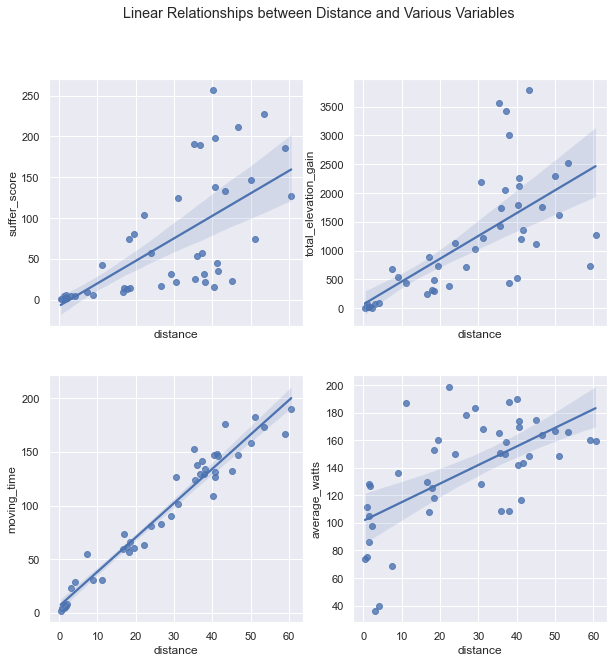

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='all')

fig.suptitle('Linear Relationships between Distance and Various Variables')

sns.regplot(
    x='distance',
    y='suffer_score',
    data=df.dropna(),
    ax=ax[0][0]
)

sns.regplot(
    x='distance',
    y='total_elevation_gain',
    data=df.dropna(),
    ax=ax[0][1]
)

sns.regplot(
    x='distance',
    y='moving_time',
    data=df.dropna(),
    ax=ax[1][0]
)

sns.regplot(
    x='distance',
    y='average_watts',
    data=df.dropna(),
    ax=ax[1][1]
)

plt.show()

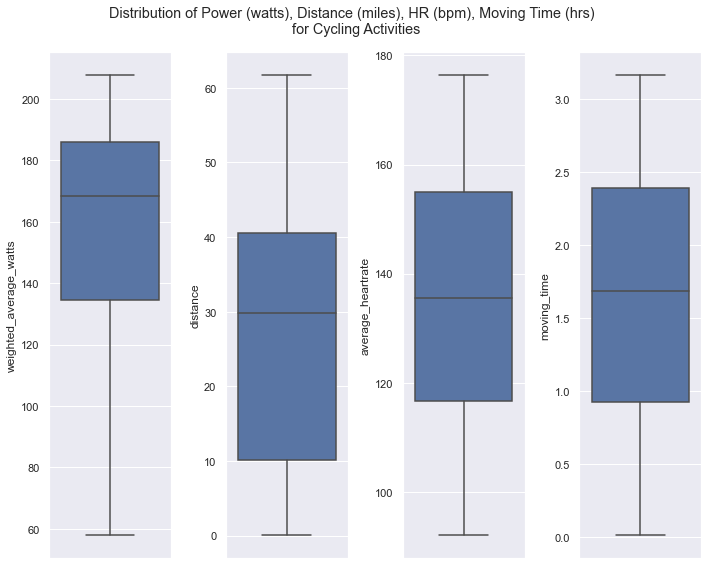

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(10, 8))

fig.suptitle('Distribution of Power (watts), Distance (miles), HR (bpm), Moving Time (hrs) \n for Cycling Activities')


sns.boxplot(
    y='weighted_average_watts',
    data=df.loc[df['sport_type'].isin(['Ride', 'VirualRide'])],
    ax=ax[0]
)

sns.boxplot(
    y='distance',
    data=df.loc[df['sport_type'].isin(['Ride', 'VirualRide'])],
    ax=ax[1]
)

sns.boxplot(
    y='average_heartrate',
    data=df.loc[df['sport_type'].isin(['Ride', 'VirualRide'])],
    ax=ax[2]
)

sns.boxplot(
    y=df.loc[df['sport_type'].isin(['Ride', 'VirualRide'])]['moving_time'] / 60,
    data=df.loc[df['sport_type'].isin(['Ride', 'VirualRide'])],
    ax=ax[3]
)

plt.tight_layout()
plt.show()

In [22]:
sport_type_timeseries = (df.loc[df['sport_type'].isin(['Ride','VirtualRide', 'Run'])]
 .pivot_table(index='date', columns='sport_type', values={'id':'count'})
 .resample('M').count()
 .query("index > '2016-12-31'")
).droplevel(0, axis=1)

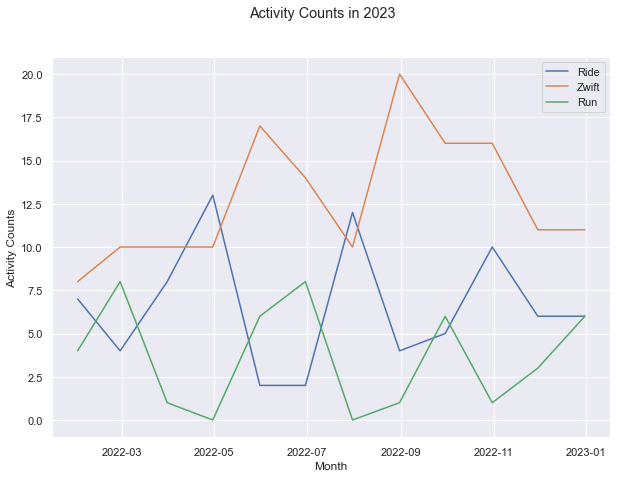

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))

fig.suptitle('Activity Counts in 2023')

ax.plot(sport_type_timeseries['Ride'], label='Ride')
ax.plot(sport_type_timeseries['VirtualRide'], label='Zwift')
ax.plot(sport_type_timeseries['Run'], label='Run')


ax.set_ylabel('Activity Counts')
ax.set_xlabel('Month')

plt.legend()

plt.show()

In [24]:
 bike_pace_pivot = df.loc[(df['sport_type'].isin(['VirtualRide', 'Ride'])) & (df['date'].dt.year > 2017), ['date', 'average_speed', 'average_watts']].set_index('date').resample('M').mean()

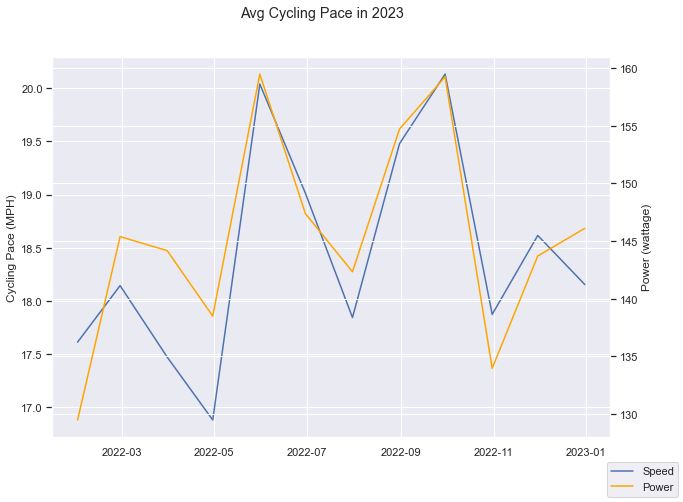

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))

fig.suptitle('Avg Cycling Pace in 2023')

ax.plot(bike_pace_pivot['average_speed'], label='Speed')

ax2 = ax.twinx()

ax2.plot(bike_pace_pivot['average_watts'], label='Power', color='orange')

ax.set_ylabel('Cycling Pace (MPH)')
ax2.set_ylabel('Power (wattage)')

fig.legend(loc='lower right')

plt.show()